<a href="https://colab.research.google.com/github/boangri/uai-thesis-notebooks/blob/main/notebooks/ActorCritic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actor Critic

In [ ]:
!pip install box2d-py

     |████████████████████████████████| 450kB 13.5MB/s 


In [ ]:
!pip install pyvirtualdisplay 
!pip install xvfbwrapper 
!apt-get update 
!apt-get install xvfb

  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-cp37-none-any.whl size=5009 sha256=71092a206de827dd41aa4d3b38e9bddb8f5a8134378f7c4cef3b9802fb112e17
  Stored in directory: /root/.cache/pip/wheels/10/f2/61/cacfaf84b352c223761ea8d19616e3b5ac5c27364da72863f0
Successfully built xvfbwrapper
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import glob 
import io 
import base64 
from IPython.display import HTML 
import time 
from IPython import display as ipythondisplay 
from pyvirtualdisplay import Display 
import gym
from gym import wrappers
from gym import logger as gymlogger 
from gym.wrappers import Monitor 
gymlogger.set_level(40)

## Classes & Functions

In [ ]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1_dims, fc2_dims, chkpt_dir, name):
        super().__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)
        self.v = nn.Linear(fc2_dims, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        pi = self.pi(x)
        v = self.v(x)

        return (pi, v)

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

In [ ]:
class Agent():
    def __init__(self, network, gamma=0.99):
        self.gamma = gamma
        self.actor_critic = network
        self.log_prob = None

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor_critic.device)
        probabilities, _ = self.actor_critic.forward(state)
        probabilities = F.softmax(probabilities, dim=1)
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()

    def learn(self, state, reward, state_, done):
        self.actor_critic.optimizer.zero_grad()

        state = T.tensor([state], dtype=T.float).to(self.actor_critic.device)
        state_ = T.tensor([state_], dtype=T.float).to(self.actor_critic.device)
        reward = T.tensor(reward, dtype=T.float).to(self.actor_critic.device)

        _, critic_value = self.actor_critic.forward(state)
        _, critic_value_ = self.actor_critic.forward(state_)

        delta = reward + self.gamma*critic_value_*(1-int(done)) - critic_value

        actor_loss = -self.log_prob*delta
        critic_loss = delta**2

        (actor_loss + critic_loss).backward()
        self.actor_critic.optimizer.step()

    def save_model(self):
        self.actor_critic.save_checkpoint()
    
    def load_model(self):
        self.actor_critic.load_checkpoint()

In [ ]:
def learn(env, agent, n_games, history_file, freq=10):
    scores = []
    for i in range(n_games):
        done = False
        observation = env.reset()
        score = 0
        steps = 0
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            steps += 1
            agent.learn(observation, reward, observation_, done)
            observation = observation_
        scores.append(score)

        if (i + 1) % freq == 0:
            avg_score = np.mean(scores[-100:])
            print('episode ', i + 1, 'score %.1f avg score %.1f steps %d' % (score, avg_score, steps))
        with open(history_file,'a') as h:   
            h.write("%d,%.3f,%d\n" % (i + 1, score, steps)) 
    agent.save_model()

In [ ]:
def test(env, agent, episodes=100):
    total = 0.
    for ep in range(episodes):
        score = 0.
        obs = env.reset()
        done = False
        while not done:
            action = agent.choose_action(obs)
            obs, reward, done, _ = env.step(action)
            score += reward

        if (ep + 1) % 10 == 0:
            print("episode: %d Score: %1.f" % (ep+1, score))
        total += score
    print("Average score %.2f" % (total/episodes))

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

def video(env, agent, seed=42):    
    env.seed(seed)
    env = wrap_env(env)
    obs = env.reset()
    done = False
    score = 0.
    while not done:
        env.render()
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(action)
        score += reward
    env.close()
    print("Score=%.2f" % score)
    show_video()

def show_video():
    mp4list = glob.glob(os.path.join(dir, 'video/*.mp4'))
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
def wrap_env(env):
    env = Monitor(env, os.path.join(dir, 'video'), force=True)
    return env

In [ ]:
def plot_history(history_file):
    df = pd.read_csv(history_file, header=None, names=('episode', 'score', 'steps'))
    x = df.episode
    y = df.score
    y1 = np.zeros_like(y)
    for i in range(len(x)):
        y1[i] = np.mean(y[i-100:i])
    steps = df.steps
    plt.figure(figsize=(12,12))
    plt.subplot(2, 1, 1)
    plt.plot(x, y, 'o', markersize=3, label='очки')
    plt.plot(x, y1, color='C1', label='среднее за 100')
    plt.ylabel('Очки')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'История обучения - {env_name} {algo}')
    plt.subplot(2, 1, 2)
    plt.scatter(x, steps, color='C2', label='steps')
    plt.ylabel('шагов на эпизод')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'История обучения - {env_name} {algo}')
    plt.show()

In [ ]:
algo='ActorCritic'
home_dir = os.path.join('/content/drive/MyDrive/Thesys', algo)

## LunarLander-v2

In [ ]:
env_name = 'LunarLander-v2'
dir = os.path.join(home_dir, env_name)
history_file = os.path.join(dir, 'history.csv')
!mkdir -p $dir 

In [ ]:
%%time
env = gym.make(env_name)
input_dims = env.observation_space.shape
n_actions = env.action_space.n
lr = 5e-6
h_dims = (2048, 1536)
n_games = 1000
gamma = 0.99

network = ActorCriticNetwork(lr=lr, input_dims=input_dims, n_actions=n_actions, fc1_dims=h_dims[0], fc2_dims=h_dims[1], chkpt_dir=dir, name='model.pt')
agent = Agent(network, gamma=gamma)



episode  10 score -308.7 avg score -180.9 steps 186
episode  20 score -645.2 avg score -252.7 steps 144
episode  30 score -92.9 avg score -235.2 steps 132
episode  40 score -104.0 avg score -241.3 steps 93
episode  50 score -269.7 avg score -233.5 steps 99
episode  60 score -182.3 avg score -234.6 steps 87
episode  70 score -506.4 avg score -238.7 steps 149
episode  80 score -243.1 avg score -237.3 steps 191
episode  90 score -190.6 avg score -233.9 steps 141
episode  100 score -51.7 avg score -228.5 steps 203
episode  110 score -240.3 avg score -231.7 steps 244
episode  120 score -179.8 avg score -221.2 steps 360
episode  130 score -102.7 avg score -221.4 steps 185
episode  140 score -292.5 avg score -211.1 steps 158
episode  150 score -214.3 avg score -209.7 steps 161
episode  160 score -218.4 avg score -201.7 steps 150
episode  170 score -92.0 avg score -185.4 steps 248
episode  180 score -217.4 avg score -176.0 steps 220
episode  190 score -234.0 avg score -170.6 steps 328
episode 

In [ ]:
!rm $history_file
# learn(env, agent, n_games, history_file)


In [ ]:
plot_history(history_file)

FileNotFoundError: ignored

In [ ]:
network = ActorCriticNetwork(lr=5e-6, input_dims=input_dims, n_actions=n_actions, fc1_dims=2048, fc2_dims=1536, chkpt_dir=dir, name='model.pt')
agent = Agent(network, gamma=0.99)
agent.load_model()

... loading checkpoint ...


In [ ]:
%%time
env = gym.make(env_name)
test(env, agent, episodes=100)

episode: 10 Score: 53
episode: 20 Score: 176
episode: 30 Score: 20
episode: 40 Score: 95
episode: 50 Score: 38
episode: 60 Score: 112
episode: 70 Score: -165
episode: 80 Score: 33
episode: 90 Score: 67
episode: 100 Score: 129
Average score 58.96
CPU times: user 2min 30s, sys: 928 ms, total: 2min 31s
Wall time: 2min 31s


In [ ]:
env = gym.make(env_name)
video(env, agent, seed=42)

NameError: ignored

## CartPole-v1

In [ ]:
env_name = 'CartPole-v1'
dir = os.path.join(home_dir, env_name)
history_file = os.path.join(dir, 'history.csv')
!mkdir -p $dir 

In [ ]:
%%time
env = gym.make(env_name)

input_dims = env.observation_space.shape
n_actions = env.action_space.n

network = ActorCriticNetwork(lr=5e-6, input_dims=input_dims, n_actions=n_actions, fc1_dims=256, fc2_dims=128, chkpt_dir=dir, name='model.pt')
agent = Agent(network, gamma=0.99)

n_games = 300

learn(env, agent, n_games, history_file)

In [ ]:
plot_history(history_file)

In [ ]:
network = ActorCriticNetwork(lr=5e-6, input_dims=input_dims, n_actions=n_actions, fc1_dims=256, fc2_dims=128, chkpt_dir=dir, name='model.pt')
agent = Agent(network, gamma=0.99)
agent.load_model()

In [ ]:
%%time
env = gym.make(env_name)
test(env, agent)

In [ ]:
env = gym.make(env_name)
video(env, agent, seed=42)

## GrandPrix-v0

In [ ]:
!pip install gym_grand_prix

In [ ]:
import gym_grand_prix

env_name = 'GrandPrix-v0'
dir = os.path.join(home_dir, env_name)
history_file = os.path.join(dir, 'history.csv')
!mkdir -p $dir 

In [ ]:
possible_actions = ((0, 0), (1, .75), (-1, .75), (0, .75), (0, -.75))

In [ ]:
%%time

track = 3
n_rays = 5
env = gym.make(env_name)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}
env.setOptions(options)
n_steps = 200
n_actions = 5
policyNetwork = PolicyNetwork(ALPHA=0.001, input_dims=env.observation_space.shape, fc1_dims=256, fc2_dims=256, n_actions=n_actions)
agent = PolicyGradientAgent(policyNetwork, GAMMA=0.99)
scores = []
num_episodes = 2500
for i in range(num_episodes):
    done = False
    score = 0
    observation = env.reset()
    steps = 0
    for step in range(n_steps):
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(possible_actions[action])
        agent.store_rewards(reward)
        observation = observation_
        done = (step == (n_steps - 1))
        score += reward/n_steps
        steps += 1
    scores.append(score)
    agent.learn()
    if (i + 1) % 10 == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', i + 1, 'score %.3f avg score %.3f steps %d' % (score, avg_score, steps))
    with open(history_file,'a') as h:   
        h.write("%d,%.3f,%d\n" % (i + 1, score, steps)) 
agent.save_model()

pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
episode  10 score -0.738 avg score -1.134 steps 200
episode  20 score -0.656 avg score -1.174 steps 200
episode  30 score -0.493 avg score -1.153 steps 200
episode  40 score -0.880 avg score -1.112 steps 200
episode  50 score -1.001 avg score -1.027 steps 200
episode  60 score 0.408 avg score -1.017 steps 200
episode  70 score -1.692 avg score -1.024 steps 200
episode  80 score 0.247 avg score -1.050 steps 200
episode  90 score 0.461 avg score -1.045 steps 200
episode  100 score -1.757 avg score -1.060 steps 200
episode  110 score -0.172 avg score -1.026 steps 200
episode  120 score -0.971 avg score -0.973 steps 200
episode  130 score 0.684 avg score -0.936 steps 200
episode  140 score 2.974 avg score -0.765 steps 200
episode  150 score 1.625 avg score -0.621 steps 200
episode  160 score -0.504 avg score -0.297 steps 200
episode  170 score 1.698 avg score -0.067 steps 200
ep

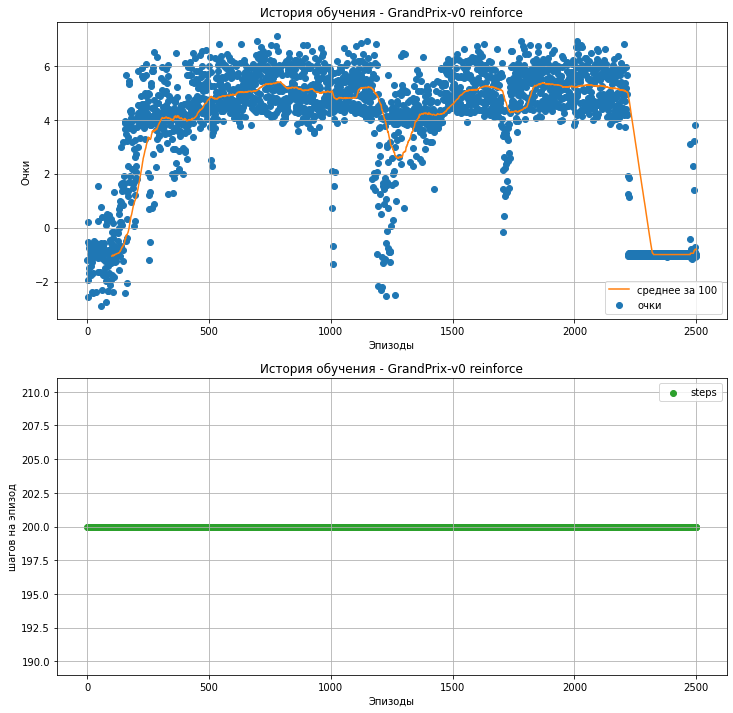

In [ ]:
plot_history(history_file)

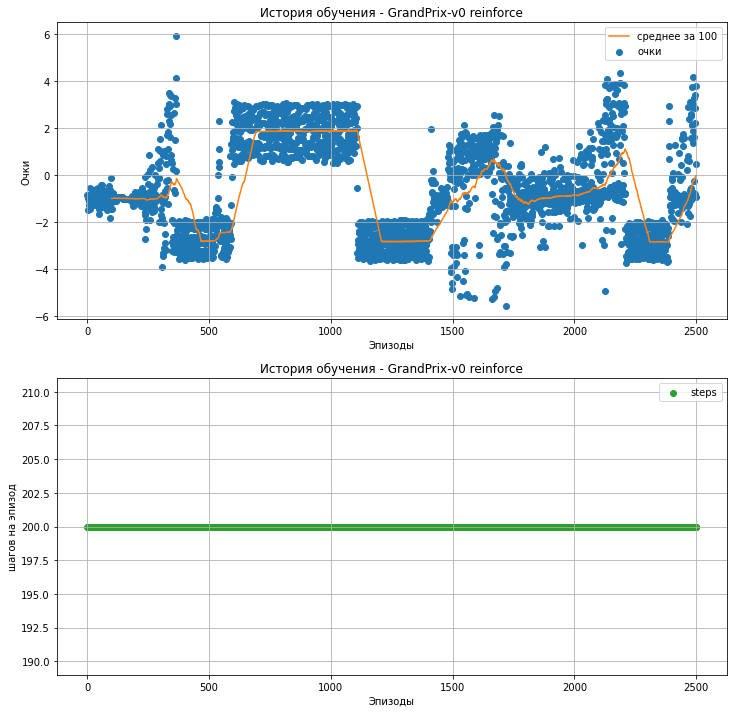

In [ ]:
plot_history(history_file)

In [ ]:
%%time

env = gym.make(env_name)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}
env.setOptions(options)
n_steps = 200
episodes = 100
total = 0.
for ep in range(episodes):
    score = 0.
    obs = env.reset()
    done = False
    for step in range(n_steps):
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(possible_actions[action])
        score += reward/n_steps
    if (ep + 1) % 10 == 0:
        print("episode: %d Score: %.3f" % (ep+1, score))
    total += score
print("Average score %.3f" % (total/episodes))

episode: 10 Score: -0.985
episode: 20 Score: -0.985
episode: 30 Score: -0.985
episode: 40 Score: -0.985
episode: 50 Score: -0.985
episode: 60 Score: -0.985
episode: 70 Score: -0.985
episode: 80 Score: -0.985
episode: 90 Score: -0.985
episode: 100 Score: -0.985
Average score -1.000
CPU times: user 1min 52s, sys: 564 ms, total: 1min 53s
Wall time: 1min 53s


In [ ]:

env = gym.make(env_name)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
    'display': 1
}
env.setOptions(options)
env = wrap_env(env)
episodes = 10
env = wrap_env(env)
obs = env.reset()
for ep in range(episodes):
    score = 0.
    for step in range(n_steps):
        env.render()
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(possible_actions[action])
        score += reward
env.close()
print("Score=%.3f" % score)
show_video()

Score=-196.952


#End